In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

In [2]:
# Define the AlexNet architecture from scratch
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # Original AlexNet was designed for 224x224 images
        # We'll adapt it for CIFAR-10's 32x32 images by using smaller filters and strides

        # Convolutional layers
        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv2
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            #nn.Linear(256 * 8 * 8, 4096),
            nn.Linear(256 * 28 * 28, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        #print("Feature shape:", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
# Data loading and preprocessing
def load_cifar10():
    # More robust data transforms for AlexNet
    transform_train = transforms.Compose([
        transforms.Resize((227, 227)),  # Explicitly resize to 227x227 (AlexNet's original input size)
        transforms.RandomCrop(227, padding=4),  # Add random cropping for data augmentation
        transforms.RandomHorizontalFlip(),  # Add horizontal flip augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet standard normalization
    ])

    transform_test = transforms.Compose([
        transforms.Resize((227, 227)),  # Consistent resizing for test data
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
        trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
        testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

        return trainloader, testloader
    except Exception as e:
        print(f"Error loading CIFAR-10 dataset: {e}")
        raise

In [4]:
# Training function
def train_model(model, trainloader, epochs=10, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    model.train()

    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        start_time = time.time()

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        epoch_time = time.time() - start_time

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {epoch_time:.2f}s')

        scheduler.step()

    return train_losses, train_accs

In [5]:
# Evaluation function
def evaluate_model(model, testloader, device='cuda'):
    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [6]:
# Set epochs and device
epochs=5
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [11]:
trainloader, testloader = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# Load and fine-tune the pretrained AlexNet from torchvision
print("\nFine-tuning pretrained AlexNet...")
pretrained_alexnet = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights.DEFAULT)
# Modify the classifier for CIFAR-10 (10 classes)
pretrained_alexnet.classifier[6] = nn.Linear(4096, 10)
pretrained_losses, pretrained_accs = train_model(pretrained_alexnet, trainloader, epochs=epochs, device=device)
pretrained_test_acc = evaluate_model(pretrained_alexnet, testloader, device=device)
print(f"Pretrained AlexNet Test Accuracy: {pretrained_test_acc:.2f}%")


Fine-tuning pretrained AlexNet...
Epoch 1/5, Loss: 0.8705, Accuracy: 70.06%, Time: 32.06s
Epoch 2/5, Loss: 0.5269, Accuracy: 81.88%, Time: 31.21s
Epoch 3/5, Loss: 0.3729, Accuracy: 87.07%, Time: 30.73s
Epoch 4/5, Loss: 0.2446, Accuracy: 91.44%, Time: 31.48s
Epoch 5/5, Loss: 0.1673, Accuracy: 94.30%, Time: 32.25s
Pretrained AlexNet Test Accuracy: 91.46%


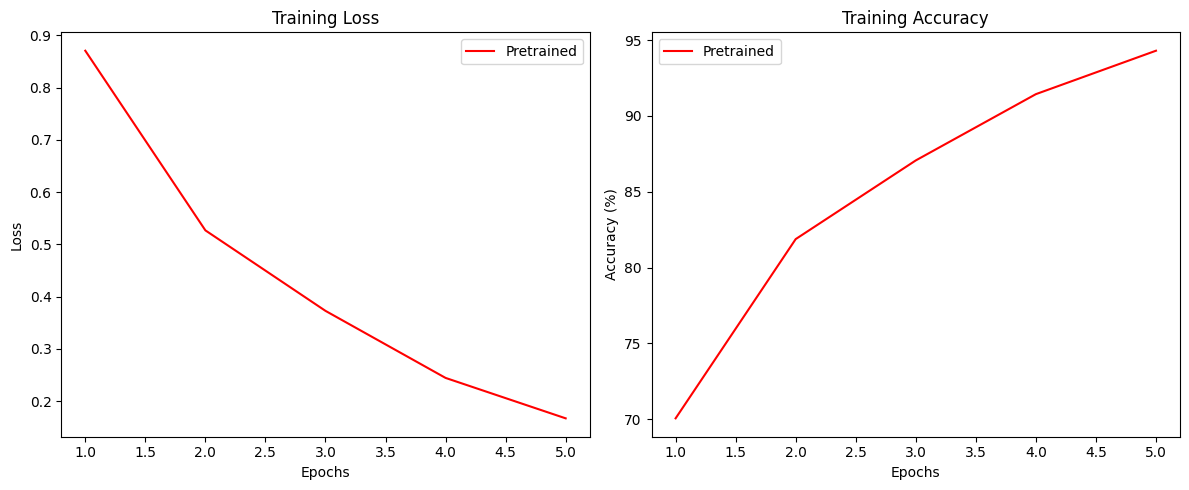

In [14]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), pretrained_losses, 'r-', label='Pretrained')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), pretrained_accs, 'r-', label='Pretrained')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()